# 数据增强

## 概述

在计算机视觉任务中，数据量过小或是样本场景单一等问题都会影响模型的训练效果，用户可以通过数据增强操作对图像进行预处理，从而提升模型的泛化性。

MindSpore提供了`c_transforms`模块和`py_transforms`模块供用户进行数据增强操作，用户也可以自定义函数或者算子进行数据增强。

|  模块   | 实现  | 说明  |
|  :----                             | :----  | :----           |
| c_transforms                      | 基于C++的OpenCV实现 | 具有较高的性能。 |
| py_transforms                     | 基于Python的PIL实现 | 该模块提供了多种图像增强功能，并提供了PIL Image和NumPy数组之间的传输方法。|

MindSpore目前支持的常用数据增强算子如下表所示，更多数据增强算子参见[API文档](https://www.mindspore.cn/doc/api_python/zh-CN/r1.1/mindspore/mindspore.dataset.vision.html)。

| 模块 | 算子 | 说明 |
| :---- | :---- | :---- |
| c_transforms | RandomCrop | 在图像随机位置裁剪指定大小子图像。 |
|  | RandomHorizontalFlip | 按照指定概率对图像进行水平翻转。 |
|  | Resize | 将图像缩放到指定大小。 |
|  | Invert | 将图像进行反相。 |
| py_transforms | RandomCrop | 在图像随机位置裁剪指定大小子图像。 |
|  | Resize | 将图像缩放到指定大小。 |
|  | Invert | 将图像进行反相。 |
|  |Compose | 将列表中的数据增强操作依次执行。 |

> 本文档适用于CPU、GPU和Ascend环境。

## c_transforms

下面将简要介绍几种常用的`c_transforms`模块数据增强算子的使用方法。

### RandomCrop

对输入图像进行在随机位置的裁剪。

**参数说明：**

- `size`：裁剪图像的尺寸。
- `padding`：填充的像素数量。
- `pad_if_needed`：原图小于裁剪尺寸时，是否需要填充。
- `fill_value`：在常量填充模式时使用的填充值。
- `padding_mode`：填充模式。

下面的样例首先使用顺序采样器加载CIFAR-10数据集[1]，然后对已加载的图片进行长宽均为10的随机裁剪，最后输出裁剪前后的图片形状及对应标签，并对图片进行了展示。

下载[CIFAR-10数据集](https://www.cs.toronto.edu/~kriz/cifar-10-binary.tar.gz)并解压到指定路径，执行如下命令：

In [1]:
!wget -N https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/datasets/cifar10.zip
!unzip -o cifar10.zip -d ./datasets
!tree ./datasets/cifar10

--2020-12-07 18:16:42--  https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/datasets/cifar10.zip
Resolving proxy-notebook.modelarts-dev-proxy.com (proxy-notebook.modelarts-dev-proxy.com)... 192.168.0.172
Connecting to proxy-notebook.modelarts-dev-proxy.com (proxy-notebook.modelarts-dev-proxy.com)|192.168.0.172|:8083... connected.
Proxy request sent, awaiting response... 200 OK
Length: 166235630 (159M) [application/zip]
Saving to: ‘cifar10.zip’

cifar10.zip         100%[===================>] 158.53M  60.7MB/s    in 2.6s    

2020-12-07 18:16:45 (60.7 MB/s) - ‘cifar10.zip’ saved [166235630/166235630]

Archive:  cifar10.zip
   creating: ./datasets/cifar10/
   creating: ./datasets/cifar10/test/
  inflating: ./datasets/cifar10/test/test_batch.bin  
   creating: ./datasets/cifar10/train/
  inflating: ./datasets/cifar10/train/batches.meta.txt  
  inflating: ./datasets/cifar10/train/data_batch_1.bin  
  inflating: ./datasets/cifar10/train/data_batch_2.bin  
  inflating: ./data

Source image Shape : (32, 32, 3) , Source label : 6
Cropped image Shape: (10, 10, 3) , Cropped label: 6
------
Source image Shape : (32, 32, 3) , Source label : 9
Cropped image Shape: (10, 10, 3) , Cropped label: 9
------
Source image Shape : (32, 32, 3) , Source label : 9
Cropped image Shape: (10, 10, 3) , Cropped label: 9
------


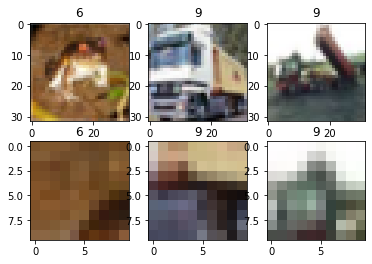

In [2]:
import matplotlib.pyplot as plt
import mindspore.dataset as ds
import mindspore.dataset.vision.c_transforms as c_trans

ds.config.set_seed(5)
ds.config.set_num_parallel_workers(1)

DATA_DIR = "./datasets/cifar10/train/"

sampler = ds.SequentialSampler(num_samples=3)
dataset1 = ds.Cifar10Dataset(DATA_DIR, sampler=sampler)

random_crop = c_trans.RandomCrop([10, 10])
dataset2 = dataset1.map(operations=random_crop, input_columns=["image"])

image_list1, label_list1 = [], []
image_list2, label_list2 = [], []
for data1, data2 in zip(dataset1.create_dict_iterator(), dataset2.create_dict_iterator()):
    image_list1.append(data1['image'])
    label_list1.append(data1['label'])
    print("Source image Shape :", data1['image'].shape, ", Source label :", data1['label'])
    image_list2.append(data2['image'])
    label_list2.append(data2['label'])
    print("Cropped image Shape:", data2['image'].shape, ", Cropped label:", data2['label'])
    print("------")

num_samples = len(image_list1) + len(image_list2)
for i in range(num_samples):
    if i < len(image_list1):
        plt.subplot(2, len(image_list1), i + 1)
        plt.imshow(image_list1[i].asnumpy())
        plt.title(label_list1[i].asnumpy())
    else:
        plt.subplot(2, len(image_list2), i + 1)
        plt.imshow(image_list2[i % len(image_list2)].asnumpy())
        plt.title(label_list2[i % len(image_list2)].asnumpy())
plt.show()

### RandomHorizontalFlip

对输入图像进行随机水平翻转。

**参数说明：**

- `prob`: 单张图片发生翻转的概率。

下面的样例首先使用随机采样器加载CIFAR-10数据集[1]，然后对已加载的图片进行概率为0.8的随机水平翻转，最后输出翻转前后的图片形状及对应标签，并对图片进行了展示。

依照上文步骤下载CIFAR-10数据集并按要求存放。

Source image Shape : (32, 32, 3) , Source label : 3
Flipped image Shape: (32, 32, 3) , Flipped label: 3
------
Source image Shape : (32, 32, 3) , Source label : 3
Flipped image Shape: (32, 32, 3) , Flipped label: 3
------
Source image Shape : (32, 32, 3) , Source label : 6
Flipped image Shape: (32, 32, 3) , Flipped label: 6
------
Source image Shape : (32, 32, 3) , Source label : 9
Flipped image Shape: (32, 32, 3) , Flipped label: 9
------


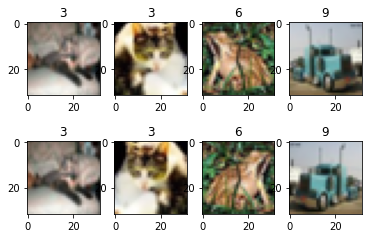

In [3]:
import matplotlib.pyplot as plt
import mindspore.dataset as ds
import mindspore.dataset.vision.c_transforms as c_trans

ds.config.set_seed(6)
ds.config.set_num_parallel_workers(1)

DATA_DIR = "./datasets/cifar10/train/"

sampler = ds.RandomSampler(num_samples=4)
dataset1 = ds.Cifar10Dataset(DATA_DIR, sampler=sampler)

random_horizontal_flip = c_trans.RandomHorizontalFlip(prob=0.8)
dataset2 = dataset1.map(operations=random_horizontal_flip, input_columns=["image"])

image_list1, label_list1 = [], []
image_list2, label_list2 = [], []
for data1, data2 in zip(dataset1.create_dict_iterator(), dataset2.create_dict_iterator()):
    image_list1.append(data1['image'])
    label_list1.append(data1['label'])
    print("Source image Shape :", data1['image'].shape, ", Source label :", data1['label'])
    image_list2.append(data2['image'])
    label_list2.append(data2['label'])
    print("Flipped image Shape:", data2['image'].shape, ", Flipped label:", data2['label'])
    print("------")

num_samples = len(image_list1) + len(image_list2)
for i in range(num_samples):
    if i < len(image_list1):
        plt.subplot(2, len(image_list1), i + 1)
        plt.imshow(image_list1[i].asnumpy())
        plt.title(label_list1[i].asnumpy())
    else:
        plt.subplot(2, len(image_list2), i + 1)
        plt.imshow(image_list2[i % len(image_list2)].asnumpy())
        plt.title(label_list2[i % len(image_list2)].asnumpy())
plt.show()

### Resize

对输入图像进行缩放。

**参数说明：**

- `self`：缩放的目标大小。
- `interpolation`：缩放时采用的插值方式。

下面的样例首先加载MNIST数据集[2]，然后将已加载的图片缩放至(101, 101)大小，最后输出缩放前后的图片形状及对应标签，并对图片进行了展示。

下载MNIST数据集并解压，存放在`./datasets/MNIST_data/`路径，执行如下命令：

In [4]:
!wget -N https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/datasets/MNIST_Data.zip
!unzip -o MNIST_Data.zip -d ./datasets
!tree ./datasets/MNIST_Data/

--2020-12-07 18:17:03--  https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/datasets/MNIST_Data.zip
Resolving proxy-notebook.modelarts-dev-proxy.com (proxy-notebook.modelarts-dev-proxy.com)... 192.168.0.172
Connecting to proxy-notebook.modelarts-dev-proxy.com (proxy-notebook.modelarts-dev-proxy.com)|192.168.0.172|:8083... connected.
Proxy request sent, awaiting response... 200 OK
Length: 10754903 (10M) [application/zip]
Saving to: ‘MNIST_Data.zip’

MNIST_Data.zip      100%[===================>]  10.26M  --.-KB/s    in 0.1s    

2020-12-07 18:17:03 (69.6 MB/s) - ‘MNIST_Data.zip’ saved [10754903/10754903]

Archive:  MNIST_Data.zip
   creating: ./datasets/MNIST_Data/test/
  inflating: ./datasets/MNIST_Data/test/t10k-images-idx3-ubyte  
  inflating: ./datasets/MNIST_Data/test/t10k-labels-idx1-ubyte  
   creating: ./datasets/MNIST_Data/train/
  inflating: ./datasets/MNIST_Data/train/train-images-idx3-ubyte  
  inflating: ./datasets/MNIST_Data/train/train-labels-idx1-ubyte  

Source image Shape : (28, 28, 1) , Source label : 5
Flipped image Shape: (101, 101, 1) , Flipped label: 5
------
Source image Shape : (28, 28, 1) , Source label : 0
Flipped image Shape: (101, 101, 1) , Flipped label: 0
------
Source image Shape : (28, 28, 1) , Source label : 4
Flipped image Shape: (101, 101, 1) , Flipped label: 4
------
Source image Shape : (28, 28, 1) , Source label : 1
Flipped image Shape: (101, 101, 1) , Flipped label: 1
------


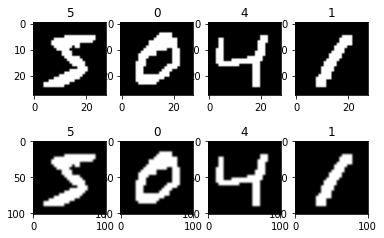

In [5]:
import matplotlib.pyplot as plt
import mindspore.dataset as ds
import mindspore.dataset.vision.c_transforms as c_trans

DATA_DIR = "./datasets/MNIST_Data/train/"

dataset1 = ds.MnistDataset(DATA_DIR, num_samples=4, shuffle=False)

resize = c_trans.Resize(size=[101, 101])
dataset2 = dataset1.map(operations=resize, input_columns=["image"])

image_list1, label_list1 = [], []
image_list2, label_list2 = [], []
for data1, data2 in zip(dataset1.create_dict_iterator(), dataset2.create_dict_iterator()):
    image_list1.append(data1['image'])
    label_list1.append(data1['label'])
    print("Source image Shape :", data1['image'].shape, ", Source label :", data1['label'])
    image_list2.append(data2['image'])
    label_list2.append(data2['label'])
    print("Flipped image Shape:", data2['image'].shape, ", Flipped label:", data2['label'])
    print("------")

num_samples = len(image_list1) + len(image_list2)
for i in range(num_samples):
    if i < len(image_list1):
        plt.subplot(2, len(image_list1), i + 1)
        plt.imshow(image_list1[i].asnumpy().squeeze(), cmap=plt.cm.gray)
        plt.title(label_list1[i].asnumpy())
    else:
        plt.subplot(2, len(image_list2), i + 1)
        plt.imshow(image_list2[i % len(image_list2)].asnumpy().squeeze(), cmap=plt.cm.gray)
        plt.title(label_list2[i % len(image_list2)].asnumpy())
plt.show()

### Invert

对输入图像进行反相处理。

下面的样例首先加载CIFAR-10数据集[1]，然后同时定义缩放和反相操作并作用于已加载的图片，最后输出缩放与反相前后的图片形状及对应标签，并对图片进行了展示。

依照上文步骤下载CIFAR-10数据集并按要求存放。

Source image Shape : (32, 32, 3) , Source label : 7
Flipped image Shape: (101, 101, 3) , Flipped label: 7
------
Source image Shape : (32, 32, 3) , Source label : 0
Flipped image Shape: (101, 101, 3) , Flipped label: 0
------
Source image Shape : (32, 32, 3) , Source label : 2
Flipped image Shape: (101, 101, 3) , Flipped label: 2
------
Source image Shape : (32, 32, 3) , Source label : 1
Flipped image Shape: (101, 101, 3) , Flipped label: 1
------


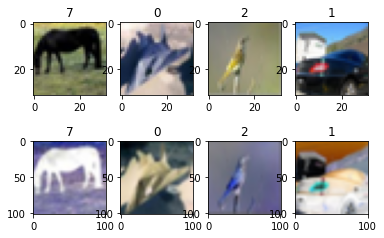

In [6]:
import matplotlib.pyplot as plt
import mindspore.dataset as ds
import mindspore.dataset.vision.c_transforms as c_trans

ds.config.set_seed(8)

DATA_DIR = "./datasets/cifar10/train/"

dataset1 = ds.Cifar10Dataset(DATA_DIR, num_samples=4, shuffle=True)

resize = c_trans.Resize(size=[101, 101])
invert = c_trans.Invert()
dataset2 = dataset1.map(operations=[resize, invert], input_columns=["image"])

image_list1, label_list1 = [], []
image_list2, label_list2 = [], []
for data1, data2 in zip(dataset1.create_dict_iterator(), dataset2.create_dict_iterator()):
    image_list1.append(data1['image'])
    label_list1.append(data1['label'])
    print("Source image Shape :", data1['image'].shape, ", Source label :", data1['label'])
    image_list2.append(data2['image'])
    label_list2.append(data2['label'])
    print("Flipped image Shape:", data2['image'].shape, ", Flipped label:", data2['label'])
    print("------")

num_samples = len(image_list1) + len(image_list2)
for i in range(num_samples):
    if i < len(image_list1):
        plt.subplot(2, len(image_list1), i + 1)
        plt.imshow(image_list1[i].asnumpy().squeeze(), cmap=plt.cm.gray)
        plt.title(label_list1[i].asnumpy())
    else:
        plt.subplot(2, len(image_list2), i + 1)
        plt.imshow(image_list2[i % len(image_list2)].asnumpy().squeeze(), cmap=plt.cm.gray)
        plt.title(label_list2[i % len(image_list2)].asnumpy())
plt.show()

## py_transforms

下面将简要介绍几种常用的`py_transforms`模块数据增强算子的使用方法。

### Compose

接收一个`transforms`列表，将列表中的数据增强操作依次作用于数据集图片。

下面的样例首先加载CIFAR-10数据集[1]，然后同时定义解码、缩放和数据类型转换操作，并作用于已加载的图片，最后输出处理后的图片形状及对应标签，并对图片进行了展示。

依照上文步骤下载CIFAR-10数据集并按要求存放。

Transformed image Shape: (3, 200, 200) , Transformed label: 7
Transformed image Shape: (3, 200, 200) , Transformed label: 0
Transformed image Shape: (3, 200, 200) , Transformed label: 2
Transformed image Shape: (3, 200, 200) , Transformed label: 1
Transformed image Shape: (3, 200, 200) , Transformed label: 6


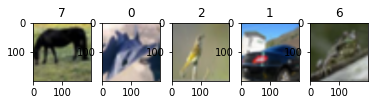

In [7]:
import matplotlib.pyplot as plt
import mindspore.dataset as ds
import mindspore.dataset.vision.py_transforms as py_trans
from mindspore.dataset.transforms.py_transforms import Compose
from PIL import Image

ds.config.set_seed(8)

DATA_DIR = "./datasets/cifar10/train/"

dataset1 = ds.Cifar10Dataset(DATA_DIR, num_samples=5, shuffle=True)

def decode(image):
    return Image.fromarray(image)

transforms_list = [
  decode,
  py_trans.Resize(size=(200,200)),
  py_trans.ToTensor()
]
compose_trans = Compose(transforms_list)
dataset2 = dataset1.map(operations=compose_trans, input_columns=["image"])

image_list, label_list = [], []
for data in dataset2.create_dict_iterator():
    image_list.append(data['image'])
    label_list.append(data['label'])
    print("Transformed image Shape:", data['image'].shape, ", Transformed label:", data['label'])

num_samples = len(image_list)
for i in range(num_samples):
    plt.subplot(1, len(image_list), i + 1)
    plt.imshow(image_list[i].asnumpy().transpose(1, 2, 0))
    plt.title(label_list[i].asnumpy())
plt.show()

## 使用说明

请勿混用`c_transforms`与`py_transforms`，因为两者作用于图片的格式不同，混用会降低处理性能。

![map](https://gitee.com/mindspore/docs/raw/r1.1/docs/programming_guide/source_zh_cn/images/map.png)

混用会引发C++与Python切换的成本，建议不要过度混用两个模块的算子，但是适量混用是可以接受的。

**推荐的使用方式：**

- 单独使用`py_transform`或`c_transform`

    ![tranform_c_py](https://gitee.com/mindspore/docs/raw/r1.1/docs/programming_guide/source_zh_cn/images/transform_recommended_1.png)

- 先使用`py_transform`，再使用`c_transform`

    ![tranform_c_py](https://gitee.com/mindspore/docs/raw/r1.1/docs/programming_guide/source_zh_cn/images/transform_recommended_2.png)

- 先使用`c_transform`，再使用`py_transform`

    ![tranform_c_py](https://gitee.com/mindspore/docs/raw/r1.1/docs/programming_guide/source_zh_cn/images/transform_recommended_3.png)

**不推荐的使用方式：**

- 在两种transform之间频繁切换

    ![tranform_c_py](https://gitee.com/mindspore/docs/raw/r1.1/docs/programming_guide/source_zh_cn/images/transform_not_recommended.png)

## 参考文献

[1] Alex Krizhevsky. [Learning Multiple Layers of Features from Tiny Images](http://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf).

[2] Y. LeCun, L. Bottou, Y. Bengio, and P. Haffner. [Gradient-based learning applied to document recognition](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf).
